In [38]:
import arff
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from operator import attrgetter, itemgetter
from io import StringIO
from sklearn.model_selection import train_test_split
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix,classification_report,precision_recall_fscore_support as score, average_precision_score
from sklearn import metrics
from sklearn.model_selection import cross_validate

from scipy.interpolate import UnivariateSpline, interp1d

import pickle

## training model
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
data = arff.load(open('../text-blob-pt/OffComBR3.arff'))
df = pd.DataFrame(data['data'])
df.columns = ['hate', 'sentence']

# transforming 'yes' into 1 and 'no' into 0
df['hate'] = df['hate'].apply(lambda x: 1 if x == 'yes' else 0)

X = df['sentence'].tolist()
y = df['hate'].tolist()
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

pt_stop_words = nltk.corpus.stopwords.words('portuguese')

classifiers = []

In [3]:
max_df = 0.01
results_x = []
results_y = []

In [4]:
# Obs: Não rode! Resultados gravados abaixo. Processo longo.
while(max_df < 1):
    RandomForest =  Pipeline([
            ('tfidf',TfidfVectorizer(ngram_range=(1,4),
                                     lowercase=True,
                                     strip_accents='ascii',
                                     max_df=max_df
                                    )),
            ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0,)),
            ])
    MLP = Pipeline([
            ('tfidf',TfidfVectorizer(ngram_range=(1, 1),                                  
                                     lowercase=True,
                                     strip_accents='ascii',
                                     max_df=max_df)),
            ('clf', MLPClassifier(activation='logistic', alpha=0, solver='lbfgs')),
            ])
    SVCl = Pipeline([
            ('tfidf',TfidfVectorizer(ngram_range=(1, 1),                        
                                     lowercase=True,
                                     strip_accents='ascii',
                                     max_df=max_df)),
            ('clf', SVC(C=4, kernel='linear', probability=True, shrinking=True, tol=1)),
            ])
    classifiers.extend([('rdf',RandomForest), ('mlp', MLP), ('svc', SVCl)])

    for classifier in classifiers:
        classifier[1].fit(X_train, y_train)

    voting = VotingClassifier(estimators=classifiers[0:3], 
                              voting='soft',
                              weights=[1, 2, 1], 
                              n_jobs=15)
    voting.fit(X_train, y_train)
    pred = voting.predict(X_test)
    report = classification_report(y_test, pred, output_dict=True)
    results_x.append(max_df)
    results_y.append(report['1'])
    max_df = round(max_df + 0.01, 2)
    print(max_df)

0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76


/home/shivwa/.virtualenvs/tcc/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


In [8]:
file_read = open('max_df_results.sav', 'rb')
a = pickle.load(file_read)

results_x = a['x']
results_y = a['y']

precision_results = [item['precision'] for item in results_y]
recall_results = [item['recall'] for item in results_y]

Text(0.5, 1.0, 'Mudanças da precisão de acordo com o max_df')

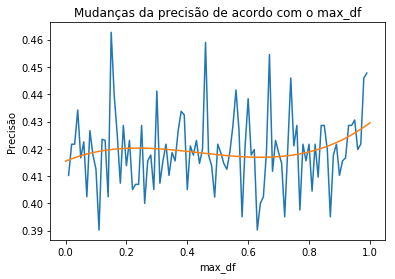

<Figure size 1000x1000 with 0 Axes>

In [52]:
fig, ax = plt.subplots()
ax.plot(results_x, precision_results)
s = UnivariateSpline(results_x, precision_results, s=5)
xs = np.linspace(0, 1, 100)
ys = s(xs)
plt.plot(xs, ys)
plt.figure(figsize=(1,1), dpi=1000)
ax.set_xlabel('max_df')
ax.set_ylabel('Precisão')
ax.set_title('Mudanças da precisão de acordo com o max_df')

Text(0.5, 1.0, 'Mudanças do recall de acordo com o max_df')

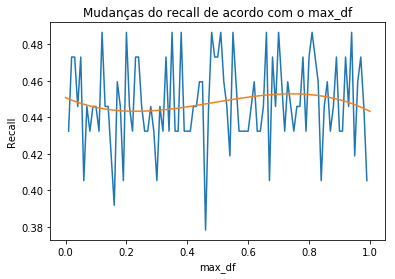

<Figure size 1000x1000 with 0 Axes>

In [53]:
fig, ax = plt.subplots()
ax.plot(results_x, recall_results)
s = UnivariateSpline(results_x, recall_results, s=5)
xs = np.linspace(0, 1, 100)
ys = s(xs)
plt.plot(xs, ys)
plt.figure(figsize=(1,1), dpi=1000)
ax.set_xlabel('max_df')
ax.set_ylabel('Recall')
ax.set_title('Mudanças do recall de acordo com o max_df')

In [4]:
file_read = open('max_df_results.sav', 'rb')
a = pickle.load(file_read)